This post relies on lessons learned in [part one]({static}/ros-analysis-part-1.html) and 
[part two]({static}/ros-analysis-part-2.html) of this three part series 
on analyzing ROS data using Jupyter Notebook. If you haven't read parts one and 
two, I highly recommend checking those out before continuing on. In the final 
part of this series, we will examine data from the test runs performed in part one. 
Our end goal is to analyze the performance of Bobble-Bot's balance controller 
during the drive square test shown below.

![BobbleSim](https://media.giphy.com/media/5QPazHiJQLuBGeiu5z/giphy.gif "Bobble-Bot Sim")

Before we get ahead of ourselves, let's load our analysis environment so 
that we can access our data using Pandas.

In [29]:
# Load anaylsis environment file. This file defines data directories
# and imports all needed Python packages for this notebook.
exec(open("nb_env.py").read())
runs = ['no_balance', 
        'balance', 
        'impulse_force', 
        'drive_square_js_response']
# Print out the df dictionary keys (the test run names)
df.keys()

Reading all bag files in directory : 
/home/mike/blogs/mike-moore/content/notebooks/ros-jup-analysis/data
Successfully loaded runs : 


['impulse_force', 'drive_square_js_response', 'balance', 'no_balance']

## Plots in Jupyter Notebook
Let's start by opening up the Jupyter Notebook for part three found [here](https://github.com/super-owesome/bobble_controllers/tree/master/analysis/notebooks/RosJupyterAnalysis). 
We ended part two after succesfully loading in the simulation data from our 
four test runs. We stopped just short of making plots within Jupyter Notebook. 
Let's pick up where we left off by creating a plot of the tilt angle during 
the balanced and un-balanced runs. This will allow us to investigate a modular 
strategy for creating plots of this data within Jupyter. This approach will 
allow us to create many different plots of interest with just a few lines of 
Python code. It will serve us well as the analysis ramps up in complexity.

## Understanding plots.yaml
In the folder containing the notebook, you will find a file called plots.yaml. 
Go ahead and open that file up in your favorite text editor and examine its 
contents. Here's a snippet from that file:

```yaml
measured_tilt:
  title : 'Tilt Angle'
  y_var: 'Tilt'
  x_label: 'Time (s)'
  y_label: 'Tilt (deg)'
  runs : ['no_balance', 'impulse_force']
  colors : ['grey', 'orange']
  linestyles: ['-' , '-']
  legend:
     no balance:
       color: 'grey'
       linestyle: '-'
     balanced:
       color: 'orange'
       linestyle: '-'
  xlim: [0.0, 10.0]
```

If you have never seen [YAML](https://yaml.org/) before, this file may seem a little mysterious. 
YAML stands for YAML Ain't Markup Language. It's a configuration format that is commonly 
used for creating configuration objects. YAML is used extensively within the ROS ecosystem. 
In fact, the Bobble-Bot balance controller is also 
[configured using YAML](https://github.com/super-owesome/bobble_controllers/blob/master/config/bobble_sim_balance_control.yaml). 
YAML allows you to encode an object within a human readable file format.
There are many open-source libraries that will parse this format and create an 
object representation in your language of choice. For our analysis, we will rely on 
[PyYAML](https://pyyaml.org/) to read our plots.yaml file. 

Using PyYAML to read this file is simple. The cell below loads in the plotting 
configuration file used for this analysis.

In [30]:
# Set paths to relevant data directories and config files
plot_config_file = os.path.abspath(
                   os.path.join(os.getcwd(),'plots.yaml'))
# Load configs and data
pc = parse_config_file(plot_config_file)

Loading configs from file : /home/mike/blogs/mike-moore/content/notebooks/ros-jup-analysis/plots.yaml


The [parse_config_file function](https://github.com/super-owesome/bobble_controllers/blob/master/src/analysis_tools/parsing.py) handles the call into PyYAML in order load our plotting configuration objects. These configuration objects hold important 
values, strings, and dictionaries that we will make use of when rendering a plot. Let's take a look at what is contained within the pc object returned by the parse_config_file function.

In [31]:
pc.keys()

['wheel_vel',
 'turning_control',
 'tilt_control',
 'heading_derived',
 'loop_jitter',
 'position_control',
 'heading_control',
 'position_derived',
 'velocity',
 'velocity_control',
 'measured_tilt',
 'heading',
 'turn_rate']

We see that pc contains a Python dictionary that maps a plot name to a plot 
configuration object (another Python dictionary). For example, if we want to 
print out the name of the variable to be plotted on the y-axis for the measured_tilt plot 
we can do the following:

In [32]:
pc['measured_tilt']['y_var']

'Tilt'

Futhermore, if we want to create a copy of a plot configuration object, we can do the 
following:

In [33]:
cfg = pc['measured_tilt'].copy()
cfg['runs'] = ['no_balance', 'balance']
print cfg['runs']

['no_balance', 'balance']


Creating copies of plot configuration objects is useful when you would like 
to create a new plot that's very similar to the template one specified in 
plots.yaml. In this way, we can quickly create a new plot configuration object 
that will inherit all the properties from the one specified in plots.yaml.
However, we can tailor the copy to meet the needs of our specific plot. 
As an example, let's use the [analysis_tools.plots module](https://github.com/super-owesome/bobble_controllers/blob/master/src/analysis_tools/plots.py)
to quickly render two plots of the same information for two different runs of the simulation.
First, let's create two plot configuration objects, one for each plot.

In [34]:
# Create two configuration objects based on the measured_tilt plot
# configuration object defined in plots.yaml
no_balance_plot = pc['measured_tilt'].copy()
no_balance_plot['runs'] = ['no_balance']
no_balance_plot['colors'] = ['red']
no_balance_plot['linestyles'] = ['-']
no_balance_plot['legend'] = {
    'no balance': {
        'color': 'red',
        'linestyle': '-'
    },
}
balance_plot = no_balance_plot.copy()
balance_plot['runs'] = ['balance']
balance_plot['colors'] = ['blue']
balance_plot['legend'] = {
    'balanced': {
        'color': 'blue',
        'linestyle': '-'
    },
}

Notice how we can also create copies of copies...nice! Next, let's render these plots 
using the make_static_plot function found in the analysis_tools.plots module:

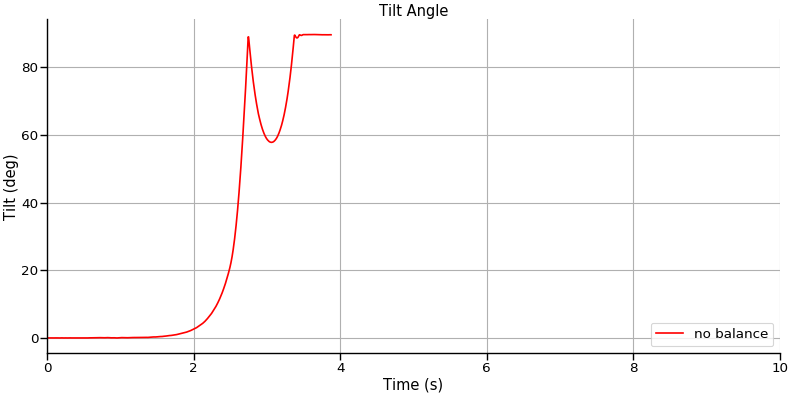

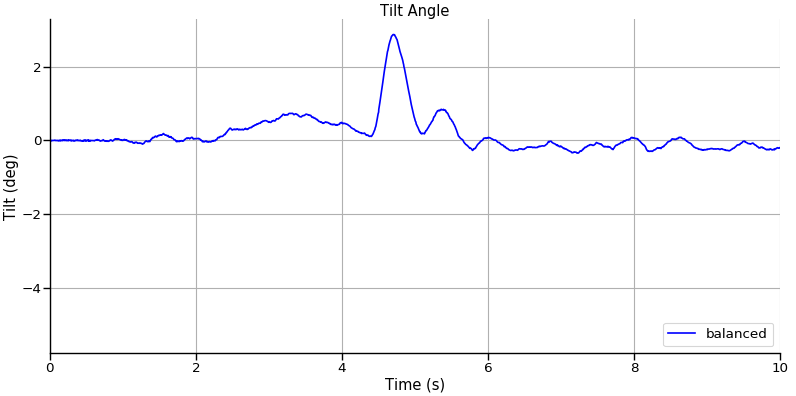

In [35]:
%matplotlib inline
make_static_plot(df, no_balance_plot, 'TiltNoBalance')
make_static_plot(df, balance_plot, 'TiltBalanced')

We can even use the same measured_tilt configuration object to co-plot both runs 
on the same plot:

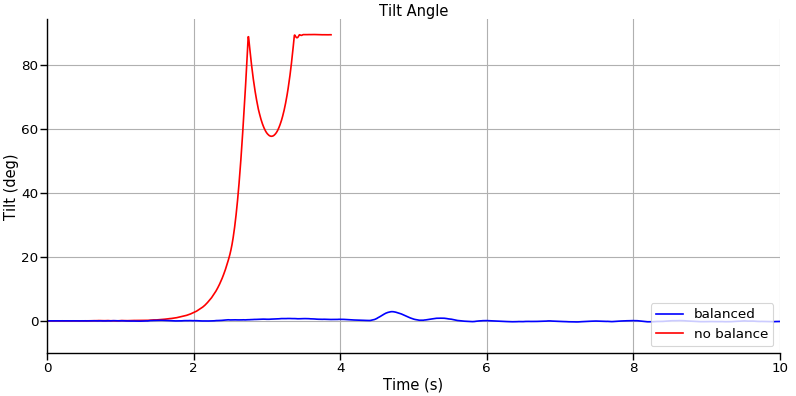

In [36]:
%matplotlib inline
balance_coplot = pc['measured_tilt'].copy()
balance_coplot['runs'] = ['no_balance', 'balance']
balance_coplot['colors'] = ['red', 'blue']
balance_coplot['linestyles'] = ['-', '-']
balance_coplot['legend'] = {
    'no balance': {
        'color': 'red',
        'linestyle': '-'
    },
    'balanced': {
        'color': 'blue',
        'linestyle': '-'
    },
}
make_static_plot(df, balance_coplot, 'TiltCoPlot')

Hopefully the examples above have illustrated how to use plots.yaml and the 
associated configuration objects to make all kinds of different plots. The great 
thing about doing your analysis in a Jupyter Notebook is that the whole process 
is interactive. Try creating your own plots by inserting some more cells 
into your notebook. I will show some more examples in the sections to follow.

## Post-Processing simulation data with NumPy
Currently, Bobble-Bot does not track its x,y world position internally because it is not needed by the balance controller. For this analysis, we will want to look at some commanded trajectories in world coordinates. In order to do this, we must post-process the simulation data. To compute the position 
in world coordinates, we can use a kinematic model for a differential drive robot. The model to be 
used is described in the graphic below. Special thanks to [Professor Magnus Egerstedt](https://www.youtube.com/watch?v=aE7RQNhwnPQ) at Georgia Tech.
<center>
  <img src="https://raw.githubusercontent.com/super-owesome/bobble_controllers/master/docs/imgs/DifferentialDrive.png" alt="Differential Drive Model" height="400" width="375"/>
</center>

The Python code below defines a function that uses this model in order to compute x, y position and velocity in world coordinates for each test run. The function relies on both 
[SciPy](https://www.scipy.org) and [NumPy](http://www.numpy.org) 
for some of the math operations.

In [46]:
import math

def compute_auxiliary_terms(df):
    fwd_vel_scale = 1.0
    turn_rate_scale = 1.0
    turn_rate = turn_rate_scale*df['TurnRate']
    heading = scipy.integrate.cumtrapz(
                      y=turn_rate.values, 
                      x=turn_rate.index)
    heading = np.append(heading, heading[-1])
    fwd_vel = fwd_vel_scale*df['ForwardVelocity']
    x_vel = fwd_vel * np.cos(heading*np.pi/180.0)
    y_vel = fwd_vel * np.sin(heading*np.pi/180.0)
    x_pos = scipy.integrate.cumtrapz(y=x_vel.values,
                                     x=x_vel.index)
    x_pos = np.append(x_pos, x_pos[-1])
    y_pos = scipy.integrate.cumtrapz(y=y_vel.values, 
                                     x=y_vel.index)
    y_pos = np.append(y_pos, y_pos[-1])
    desired_fwd_vel = fwd_vel_scale*df['DesiredVelocity']
    desired_turn_rate = turn_rate_scale*df['DesiredTurnRate']
    desired_heading = scipy.integrate.cumtrapz(
                      y=desired_turn_rate.values, 
                      x=desired_turn_rate.index)
    desired_heading = np.append(desired_heading, 
                                desired_heading[-1])
    desired_x_vel = desired_fwd_vel * np.cos(desired_heading*np.pi/180.0)
    desired_y_vel = desired_fwd_vel * np.sin(desired_heading*np.pi/180.0)
    desired_x_pos = scipy.integrate.cumtrapz(
                      y=desired_x_vel.values, 
                      x=desired_x_vel.index)
    desired_x_pos = np.append(desired_x_pos, 
                              desired_x_pos[-1])
    desired_y_pos = scipy.integrate.cumtrapz(
                      y=desired_y_vel.values, 
                      x=desired_y_vel.index)
    desired_y_pos = np.append(desired_y_pos, desired_y_pos[-1])
    df['Heading'] = heading
    df['DerivedHeading'] = heading
    df['DesiredHeading'] = desired_heading
    df['DesiredXPos'] = desired_x_pos
    df['DesiredYPos'] = desired_y_pos
    df['DerivedXPos'] = x_pos
    df['DerivedYPos'] = y_pos

Let's loop over all our runs and call this function so that we have this position 
data for each data set.

In [47]:
for run in runs:
    compute_auxiliary_terms(df[run])

## Analyzing the impulse force test
Our data is now ready for further analysis. Let's start with a simple case, the impulse force test. 
This is a useful test for evaluating the balance controller as it allows us to look at how the 
controller responds to an applied impulse force. Let's look at the tilt and velocity control 
performance after the impulse is applied.

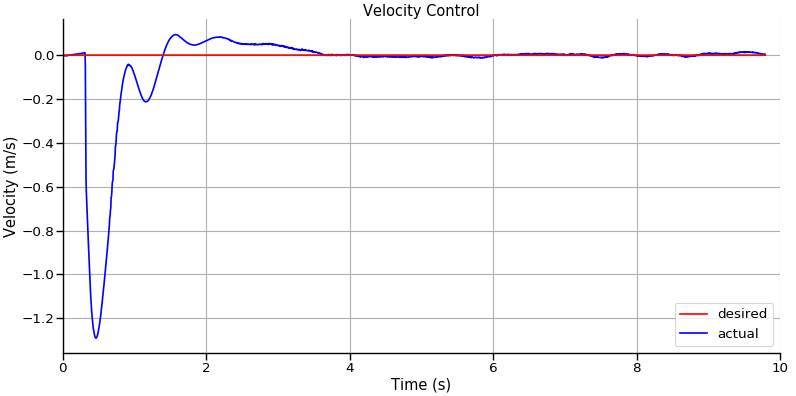

In [39]:
%matplotlib inline
cfg = pc['velocity_control'].copy()
cfg['runs'] = ['impulse_force']
cfg['xlim'] = [0, 10]
make_static_plot(df, cfg, 'ImpulseVelocityControl', plot_func=desired_vs_actual_for_runs)

This plot shows what you would expect for an impulse force applied in the -X direction. During this 
test the robot is in the balance mode. In this mode, the robot is trying to hold zero velocity. The 
applied impulse causes the robot to quickly accelerate in the -X direction. The job of the velocity 
controller is to reject this impulse by controlling the velocity back to zero. The plot above shows 
that the velocity controller is able to achieve its goal. In order to reject the -X disturbance force, 
the velocity controller modulates the desired tilt. In response to the -X impulse, the velocity controller 
commands the robot to tilt forward. The tilt controller then commands torque to each motor to achieve 
this tilt angle. This tilting motion serves to simultaneously control the velocity and reject the 
disturbance. Let's look at the tilt response to see this in action.

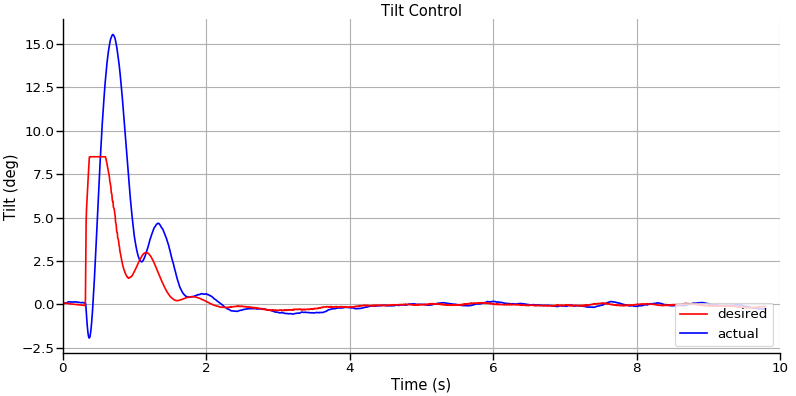

In [40]:
%matplotlib inline
cfg = pc['tilt_control'].copy()
cfg['runs'] = ['impulse_force']
cfg['xlim'] = [0, 10]
make_static_plot(df, cfg, 'ImpulseTiltControl', plot_func=desired_vs_actual_for_runs)

Here we see the velocity controller commanding a positive tilt to the tilt controller (red line) in response to the -X impulse. In response to this forward tilt, the tilt controller successfully tilts 
the robot forward. This tilting motion causes the robot to begin to accelerate back in the +X 
direction. The velocity controller detects this change in velocity and begins to ramp down the 
forward tilt command until it is zero. This tilting motion brings the robot back to its balanced 
and rested state. The balance controller has successfully used its velocity and tilt controllers 
simultaneously to reject the impulse force and remain standing.

## Analyzing the Balance Test
This section will look at the data from the balance test in more detail. This test lasts about thirty seconds. During the test, the robot is commanded to drive forward and then backward. After those 
commands are executed, the robot is commanded to turn right and then back to the left. Let's make 
some plots to confirm the robot performs as expected.

### Commands vs Response
Using the velocity control plot as our template, we make some slight modifications to use the balance 
run and limit the x axis to between 0 and 35 seconds. The plot below should show the velocity being 
commanded to 0.1 m/s, -0.1 m/s, and back to rest. We expect the robot to respond to these commands 
appropriately with some tolerance for noise and error in the state.

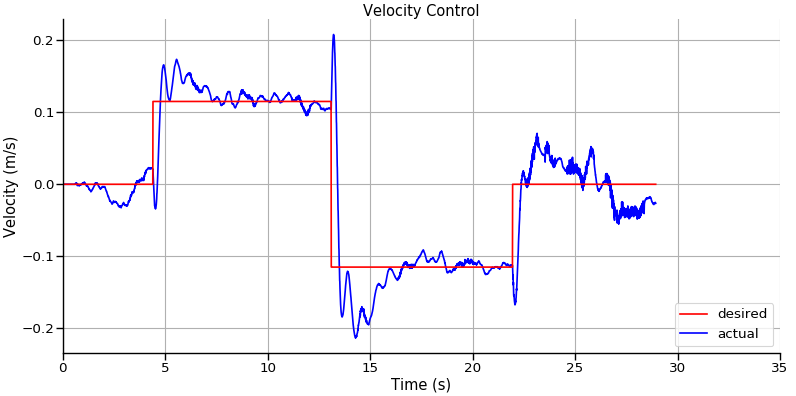

In [41]:
%matplotlib inline
cfg = pc['velocity_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [0, 35]
make_static_plot(df, cfg, 'VelocityControl', plot_func=desired_vs_actual_for_runs)

In order to drive forward and backward, Bobble-Bot's velocity controller commands a 
positive and then negative tilt to the tilt controller. The effort sent to each motor 
in order to track this tilt command causes the robot to drive forward and then backward. 
We can confirm this behavior by analyzing the tilt controller performance.

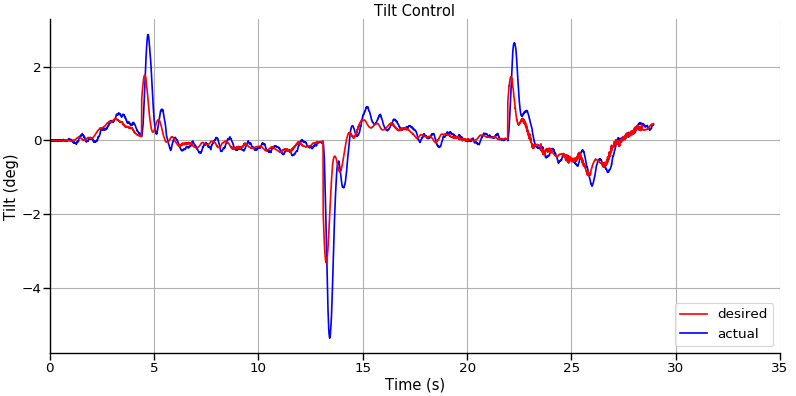

In [42]:
%matplotlib inline
cfg = pc['tilt_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [0, 35]
make_static_plot(df, cfg, 'TiltControl', plot_func=desired_vs_actual_for_runs)

The plots above confirm the velocity and tilt control performance during the balance test.
Let's now look at the turning commands that were sent during the test.

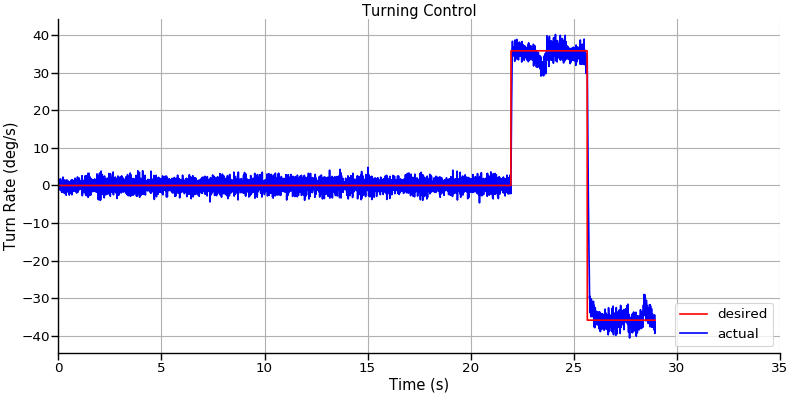

In [43]:
%matplotlib inline
cfg = pc['turning_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [0, 35]
make_static_plot(df, cfg, 'TurningControl', plot_func=desired_vs_actual_for_runs)

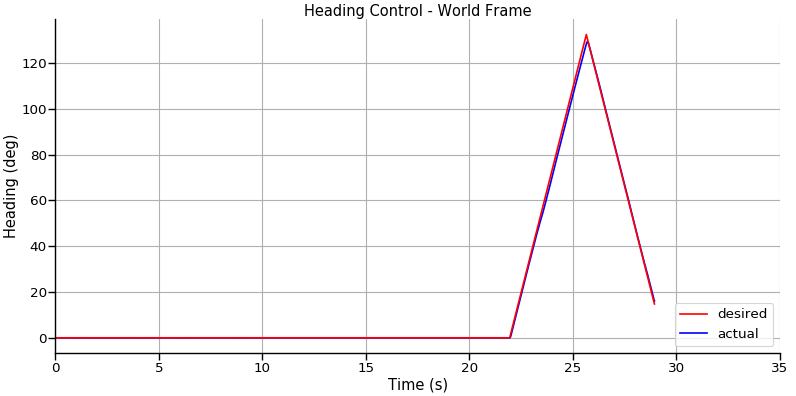

In [44]:
%matplotlib inline
cfg = pc['heading_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [0, 35]
make_static_plot(df, cfg, 'HeadingControl', plot_func=desired_vs_actual_for_runs)

This concludes our analysis of the balance test. The last test to look at is the drive square test. 

## Analyzing the Drive Square Test
The drive square test is performed by issuing a canned set of joystick commands to drive 
Bobble-Bot in a square. These commands were generated by manually driving the robot during 
a simulation run and logging the joystick command data using [rosbag record](http://wiki.ros.org/rosbag/Tutorials/Recording%20and%20playing%20back%20data).
The previous sections have served to validate the velocity, tilt, and turning controller. This 
final plot will show all of these controllers working together to track a commanded trajectory. 
The plot below shows the commanded position in X,Y world coordinates versus the actual X,Y 
position.

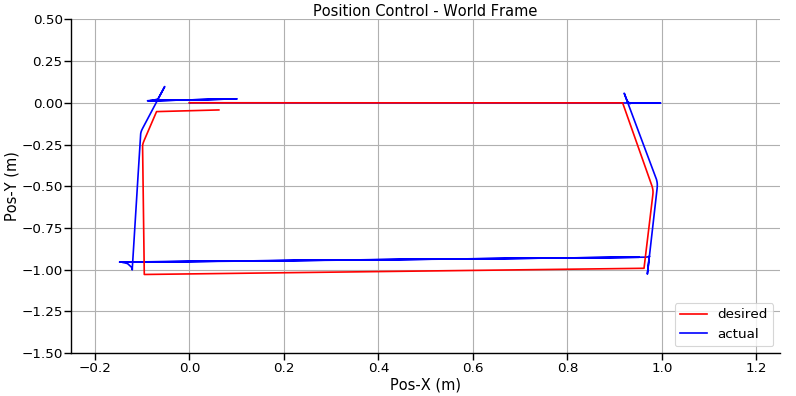

In [45]:
%matplotlib inline
cfg = pc['position_control'].copy()
cfg['runs'] = ['drive_square_js_response']
cfg['xlim'] = [-0.25, 1.25]
cfg['ylim'] = [-1.5, 0.5]
make_static_plot(df, cfg, 'PositionControl', plot_func=desired_vs_actual_for_runs)

Bobble-Bot's balance controller seems to be working as expected!

# Conclusion
Hopefully this post has provided a good introduction to using Jupyter Notebook 
for ROS robots. Keep in mind, Jupyter is not limited to ROS applications. It 
can be used in a wide variety of analysis and data science applications. Jupyter 
notebooks give others a chance to reproduce your results. They are meant 
to be shared with others so that they can interact with your work and check or 
extend your results. In that spirit, you can find the Jupyter Notebooks that 
were used to create this blog post series [here](https://github.com/super-owesome/bobble_controllers/tree/master/analysis/notebooks/RosJupyterAnalysis).

This post concludes the three part series on using Jupyter to analyze ROS data. 
As always, feel free to [contact me]({static}/pages/contact.html) or leave a question in the discussion section 
below. Thanks for reading!